# MECE 6397: Project 3

Syam Evani <br>
08/09/2025 <br>

## <span style="color: blue;">Introduction</span>

###  Table of Contents
1. [Part 1: Dataset EDA](#part-1)
2. [Part 2: Prepare Dataset](#part-2)
3. [Part 3: F-testing and discussion](#part-3)
4. [Part 4: SVM fitting by adding features](#part-4)
5. [Part 5: SVM accuracy discussion](#part-5)
5. [Part 6: Kernel exploration](#part-6)
6. [Code for Part 3-6](#code)

My code for this project is included in three ways:
- Embedded in portions with relevant discussion
- Uploaded as part of this deliverable on Canvas
- Available on a public github here: <a> https://github.com/Sam-v6/mece-6397-doe/tree/main/project3 <a>

<a id="part-1"></a>
## <span style="color: blue;">Part 1: Dataset EDA</span>
Ingesting the data and then performing some basic data analysis, we can get statitics as shown following the code excerpt that shows the mean, standard deviations, min, max, and frequency of the different values for the different categories fo data. I've also provided the following plots:

- Histograms of the age, salary, awards, and ratings
- Bar charts of department, location, recruiting type, and education
- Box and whisker plots age. salary, awards, and ratings


This overall data anlaysis helps us understand the trends of the data and overal composition of the data prior to applying SVM fit

         emp_id         age        Dept location education recruitment_type  \
count       500  500.000000         500      500       500              500   
unique      499         NaN           5        2         2                4   
top     MKT7287         NaN  Purchasing     City        PG        On-Campus   
freq          2         NaN         109      259       254              133   
mean        NaN   38.610000         NaN      NaN       NaN              NaN   
std         NaN    9.438648         NaN      NaN       NaN              NaN   
min         NaN   23.000000         NaN      NaN       NaN              NaN   
25%         NaN   30.000000         NaN      NaN       NaN              NaN   
50%         NaN   39.000000         NaN      NaN       NaN              NaN   
75%         NaN   47.000000         NaN      NaN       NaN              NaN   
max         NaN   54.000000         NaN      NaN       NaN              NaN   

         job_level      rating      onsite      awa

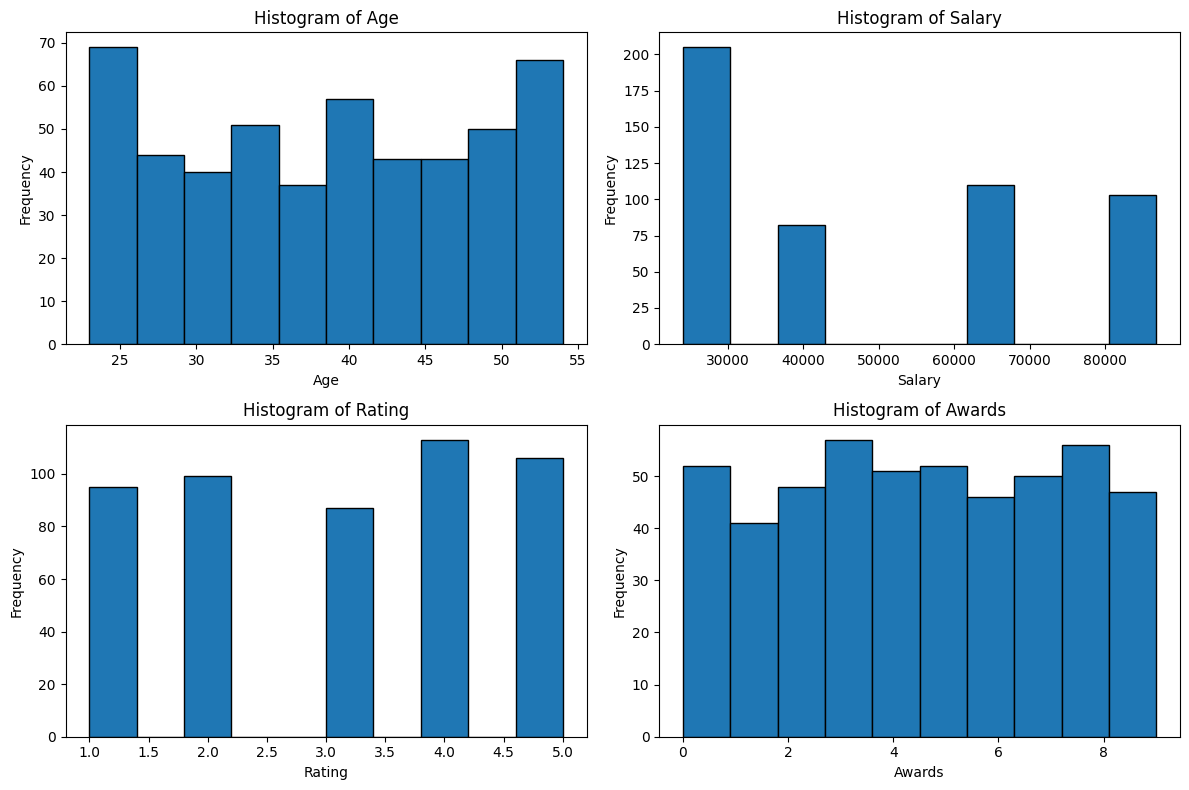

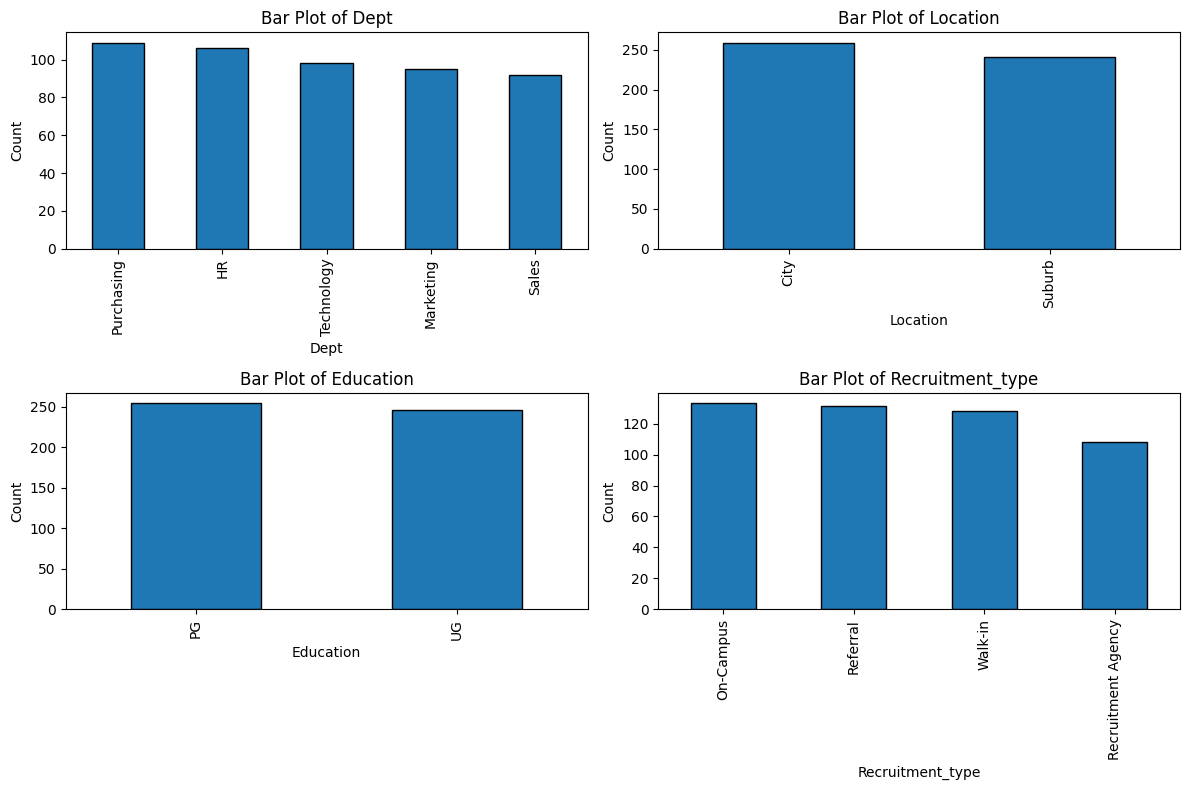

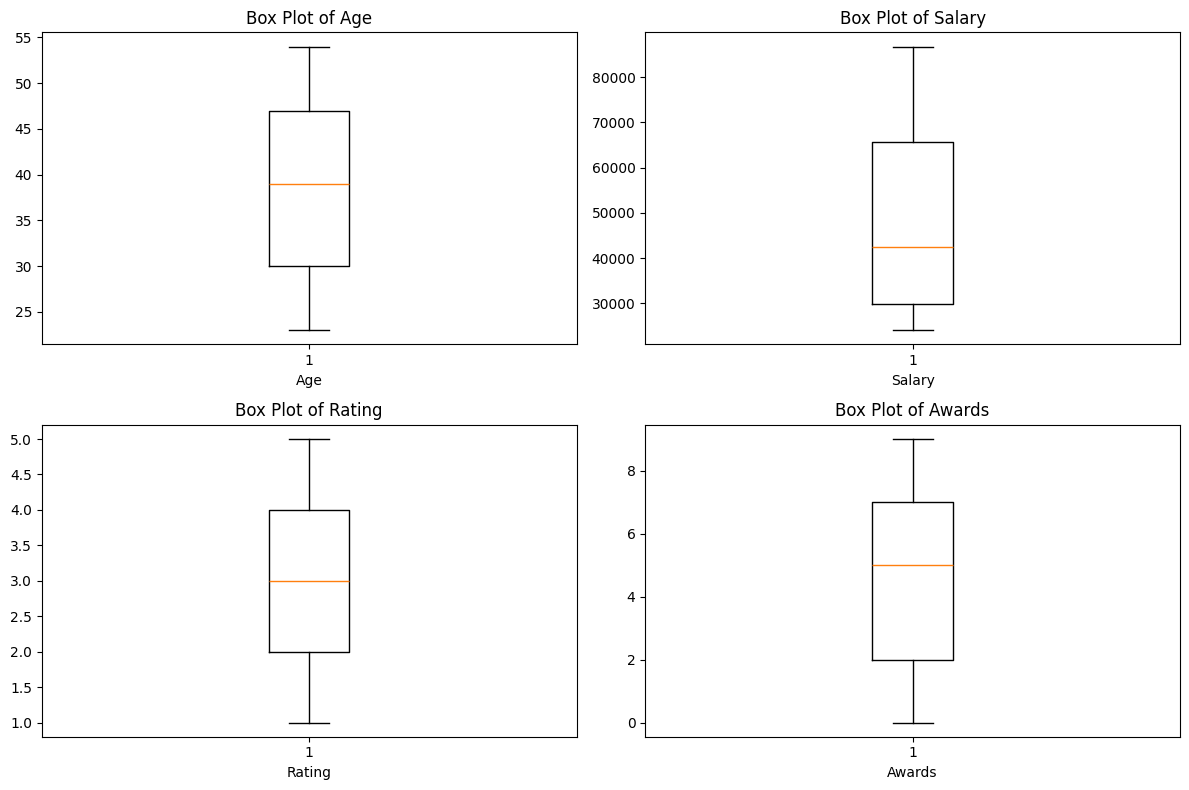

In [3]:
"""
Purpose: Project 3 - Analysis on sample data with F test and SVM classification
Author: Syam Evani
"""

# Standard imports
import os
import time

# Additional imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import f

# Local imports
# None

#----------------------------------------------------------
# Data collection and analysis
#----------------------------------------------------------
# Assuming you have a dataset with features and target variable (customer satisfaction)
data = pd.read_csv(os.path.join(os.getenv('USERPROFILE'),'repos','mece-6397-doe','project3','ref','Employee Satisfaction Index.csv'))
sample_number = len(data)

# Generate summary statistics
summary_stats = data.describe(include='all')
print(summary_stats)

# Histograms
numerical_columns = ['age', 'salary', 'rating', 'awards']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numerical_columns):
    axs[i//2, i%2].hist(data[col], bins=10, edgecolor='black')
    axs[i//2, i%2].set_title(f'Histogram of {col.capitalize()}')
    axs[i//2, i%2].set_xlabel(col.capitalize())
    axs[i//2, i%2].set_ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(os.getenv('USERPROFILE'), 'repos', 'mece-6397-doe', 'project3', 'output', 'histogram.png'))

# Bar plots
categorical_columns = ['Dept', 'location', 'education', 'recruitment_type']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(categorical_columns):
    data[col].value_counts().plot(kind='bar', ax=axs[i//2, i%2], edgecolor='black')
    axs[i//2, i%2].set_title(f'Bar Plot of {col.capitalize()}')
    axs[i//2, i%2].set_xlabel(col.capitalize())
    axs[i//2, i%2].set_ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(os.getenv('USERPROFILE'), 'repos', 'mece-6397-doe', 'project3', 'output', 'bar_plot.png'))

# Box & whisker plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numerical_columns):
    axs[i//2, i%2].boxplot(data[col])
    axs[i//2, i%2].set_title(f'Box Plot of {col.capitalize()}')
    axs[i//2, i%2].set_xlabel(col.capitalize())
plt.tight_layout()
plt.savefig(os.path.join(os.getenv('USERPROFILE'), 'repos', 'mece-6397-doe', 'project3', 'output', 'box_whisker_plot.png'))

<br>

<a id="part-2"></a>
## <span style="color: blue;">Part 2: Dataset preparation</span>

I've prepared the dataset with sample code which replaces the string values (i.e. department names, location, education, recruitment type) with numerical values. I've then standardized the dataset wtih the sample code to ensure that the different model categories are evaluted fairly (by standardizing the data with similar ranges and standard deviations)

In [4]:
#----------------------------------------------------------
# Prepare the dataset
#----------------------------------------------------------
# Converting catgetorial to numberial values for those columns
cleanup_nums = {"Dept":     {"Purchasing": 1, "HR": 2, "Technology":3, "Marketing":4, "Sales":5},
                "location": {"City": 1, "Suburb": 2},
                "education": {"PG":1, "UG":2},
                "recruitment_type": {"On-Campus":1, "Referral":2, "Walk-in":3, "Recruitment Agency":4}}

# Replace the values in the dataframe
data = data.replace(cleanup_nums)

# Assuming the last column is the target variable
X = data.iloc[:, 1:-1]  # features
y = data.iloc[:, -1]    # target

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the data
X_normalized = scaler.fit_transform(X)
print(X_normalized)

[[-1.12522746 -0.64316174  1.03667198 ... -1.24124642 -0.99203175
   1.5364678 ]
 [ 1.20794918  0.0636094   1.03667198 ... -0.89041363  1.00803226
  -0.33817466]
 [ 0.46557479  0.0636094   1.03667198 ... -0.89041363 -0.99203175
   0.64695247]
 ...
 [-0.48890656  0.77038055 -0.96462528 ... -0.89041363 -0.99203175
  -1.11385232]
 [-1.33733443  0.0636094  -0.96462528 ... -1.24124642  1.00803226
  -0.87158784]
 [-1.33733443  0.0636094  -0.96462528 ... -0.53958084 -0.99203175
  -0.33817466]]


<br>

<a id="part-3"></a>
## <span style="color: blue;">Part 3: F-testing and initial results discussion</span>

Note, I have combined my code for parts 3-6 in a large loop that iterates on the number of features and kernel type for the SVM model. This full code is provided below but I will provide some excerpts that speak to the relevant portions.

To perform the F-testing, I used the sample code that was automatically set to include 10 feature groups as well as the critical F calculation. Looking at the results we get the following:

| Feature            | F-score | P-value  |
|--------------------|---------|----------|
| age                | 0.00    | 0.9760   |
| Dept               | 1.57    | 0.2107   |
| location           | 0.34    | 0.5625   |
| education          | 0.47    | 0.4940   |
| recruitment_type   | 0.12    | 0.7303   |
| job_level          | 0.18    | 0.6704   |
| rating             | 5.19    | 0.0233   |
| onsite             | 0.89    | 0.3448   |
| awards             | 0.12    | 0.7283   |
| certifications     | 0.50    | 0.4815   |
| salary             | 0.00    | 0.9588   |

The critical F-value for these 10 groups (with 500 samples) and 95% confidence was 1.90. Given the rankings of F-scores, the actual 10 selected features were:
- department
- location
- education
- recruitment type
- job level
- rating
- awards
- salary
- onsite

With an overall accuracy of 44%. 

Note that all factors (except performance rating) have high P-values and F-scores being much lower than the critical F-value, indicating that if just evaluated alone, these parameters are poor predictors of job satisfaction. Performnace rating has a P-value below 0.05 (indicating statistical significance) and a F-score above the critical F-value, overall indicating that rating is a strong predictor of job satisfaction.

<br>

<a id="part-4"></a>
## <span style="color: blue;">Part 4: SVM fitting by adding features</span>

As noted, code implementation for how I incremendatally added features into the SVM model by F-scores is shown below (I simply iterate from 1 to 11 and allow the best F score features to be added into the SVM fit model). If we keep the linear kernel and allow the iteration of the SVM model from 1 to 11 features we would get an output like something below:

<br>

In [ ]:
## 1 Group
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 1 groups and 500 samples at 95.0% confidence level is: nan
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        47
           1       0.54      0.36      0.43        53

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.49       100
weighted avg       0.51      0.50      0.49       100

Selected features: Index(['rating'], dtype='object')

## 2 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 2 groups and 500 samples at 95.0% confidence level is: 3.8601992711913966
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        47
           1       0.54      0.36      0.43        53

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.49       100
weighted avg       0.51      0.50      0.49       100

Selected features: Index(['Dept', 'rating'], dtype='object')

## 3 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 3 groups and 500 samples at 95.0% confidence level is: 3.0138622207622765
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.47      0.47      0.47        47
           1       0.53      0.53      0.53        53

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100

Selected features: Index(['Dept', 'rating', 'onsite'], dtype='object')

## 4 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 4 groups and 500 samples at 95.0% confidence level is: 2.6228791395073507
Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.48      0.47      0.47        47
           1       0.54      0.55      0.54        53

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.51      0.51      0.51       100

Selected features: Index(['Dept', 'rating', 'onsite', 'certifications'], dtype='object')

## 5 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 5 groups and 500 samples at 95.0% confidence level is: 2.38994784445829
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.46      0.40      0.43        47
           1       0.53      0.58      0.55        53

    accuracy                           0.50       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.50      0.50      0.50       100

Selected features: Index(['Dept', 'education', 'rating', 'onsite', 'certifications'], dtype='object')

## 6 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 6 groups and 500 samples at 95.0% confidence level is: 2.2322612706136007
Accuracy: 0.47
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        47
           1       0.50      0.51      0.50        53

    accuracy                           0.47       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.47      0.47       100

Selected features: Index(['Dept', 'location', 'education', 'rating', 'onsite', 'certifications'], dtype='object')

## 7 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 7 groups and 500 samples at 95.0% confidence level is: 2.1169593191758156
Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.45      0.43      0.44        47
           1       0.52      0.55      0.53        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100

Selected features: Index(['Dept', 'location', 'education', 'job_level', 'rating', 'onsite',
       'certifications'],
      dtype='object')

## 8 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 8 groups and 500 samples at 95.0% confidence level is: 2.0281829252880588
Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.46      0.45      0.45        47
           1       0.52      0.53      0.52        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100

Selected features: Index(['Dept', 'location', 'education', 'job_level', 'rating', 'onsite',
       'awards', 'certifications'],
      dtype='object')

## 9 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 9 groups and 500 samples at 95.0% confidence level is: 1.9572531865713738
Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.44      0.43      0.43        47
           1       0.51      0.53      0.52        53

    accuracy                           0.48       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.48      0.48      0.48       100

Selected features: Index(['Dept', 'location', 'education', 'recruitment_type', 'job_level',
       'rating', 'onsite', 'awards', 'certifications'],
      dtype='object')

## 10 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 10 groups and 500 samples at 95.0% confidence level is: 1.8989833990552476
Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.39      0.34      0.36        47
           1       0.47      0.53      0.50        53

    accuracy                           0.44       100
   macro avg       0.43      0.43      0.43       100
weighted avg       0.43      0.44      0.44       100

Selected features: Index(['Dept', 'location', 'education', 'recruitment_type', 'job_level',
       'rating', 'onsite', 'awards', 'certifications', 'salary'],
      dtype='object')

## 11 Groups
Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 11 groups and 500 samples at 95.0% confidence level is: 1.8500646331252697
Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.41      0.36      0.39        47
           1       0.49      0.55      0.52        53

    accuracy                           0.46       100
   macro avg       0.45      0.45      0.45       100
weighted avg       0.46      0.46      0.46       100

Selected features: Index(['age', 'Dept', 'location', 'education', 'recruitment_type', 'job_level',
       'rating', 'onsite', 'awards', 'certifications', 'salary'],
      dtype='object')

## Groups and Accuracy
{'linear': {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.51, 5: 0.5, 6: 0.47, 7: 0.49, 8: 0.49, 9: 0.48, 10: 0.44, 11: 0.46}}

<a id="part-5"></a>
## <span style="color: blue;">Part 5: SVM Accuracy Discussion </span>

For our linear kernel, varying the number of groups we get the following results for accuracy:
| Groups | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11   |
|--------|------|------|------|------|------|------|------|------|------|------|------|
| Acccuracy | 0.5  | 0.5  | 0.5  | 0.51 | 0.5  | 0.47 | 0.49 | 0.49 | 0.48 | 0.44 | 0.46 |

As evidenced above, we can see the that early on with just a few groups we actually have the strongest accuracy prediction. This makes sense as we noted from initial F-score inspection that really only one factor (rating) was having any significant predictive impact on overall job satisfication. The maximum accuracy value (just barely) is at 4 groups. However, past this, accuracy will decrease, dropping to a minimum of 46% (indicating we are more wrong than right) when including all 11 groups.

<a id="part-6"></a>
## <span style="color: blue;">Part 6: Kernel Exploration & Analysis </span>

In addition to linear, I also evaluted:
- Poly: projects data into a higher dimensional space with a polynomial function
- Radial Basis Function (RBF): Uses a gaussian function to project data into higher dimensions
- Sigmoid: Uses sigmoid function for projection

This is implemented in python code by iterating across these strings that with some conditional logic i make a unique SVM call for these different methods. As noted earlier, full code that shows is provided at the end of this notebook. 

Accuracy results for different kernels across different groups are shown below:
| Group | Linear | Poly | RBF | Sigmoid |
|-------|--------|------|-----|---------|
| 1     | 0.5    | 0.49 | 0.47 | 0.5    |
| 2     | 0.5    | 0.49 | 0.49 | 0.47   |
| 3     | 0.5    | 0.49 | 0.48 | 0.42   |
| 4     | 0.51   | 0.53 | 0.49 | 0.5    |
| 5     | 0.5    | 0.56 | 0.55 | 0.45   |
| 6     | 0.47   | 0.59 | 0.55 | 0.39   |
| 7     | 0.49   | 0.56 | 0.51 | 0.4    |
| 8     | 0.49   | 0.58 | 0.51 | 0.39   |
| 9     | 0.48   | 0.55 | 0.47 | 0.48   |
| 10    | 0.44   | 0.6  | 0.48 | 0.53   |
| 11    | 0.46   | 0.55 | 0.47 | 0.46   |

As we can see above, polynominal approximations yield the best overall accuracy predictions when considering 10 groups and across the board do quite well. RBF performs slightly worse than a linear SVM fitting where as the sigmoid aproximation really struggles with this data set, yielding the lowest overall accuracy predictions.

<a id="code"></a>
## <span style="color: blue;">Code Implementation for Parts 3-6 </span>

In [7]:
#----------------------------------------------------------
# Iterate across k groups 
#----------------------------------------------------------
# Init
accuracy_dict = {"linear": {}, "poly": {}, "rbf": {}, "sigmoid": {}}
kernel_list = ["linear", "poly", "rbf", "sigmoid"]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

for kernel_type in kernel_list:
    for k_value in range(1,12):
        # Feature Selection using F-test
        # Select the top 'k' features
        selector = SelectKBest(score_func=f_classif, k=k_value)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        #----------------------------------------------------------
        # F-testing
        #----------------------------------------------------------
        # Get the scores (F-values) computed by f_classif
        f_scores = selector.scores_

        # Optional: get p-values to understand significance
        p_values = selector.pvalues_

        # Print the feature names with their corresponding F-scores
        for feature, score, p_value in zip(X.columns, f_scores, p_values):
            print(f"Feature: {feature}, F-score: {score:.2f}, P-value: {p_value:.4f}")

        #----------------------------------------------------------
        # Calculate critical F value
        #----------------------------------------------------------
        def calculate_critical_f_value(num_groups, total_samples, confidence_level=0.95):
            # Calculate degrees of freedom
            df_between = num_groups - 1  # Degrees of freedom for the numerator (between groups)
            df_within = total_samples - num_groups  # Degrees of freedom for the denominator (within groups)

            # Calculate the critical F-value at the specified confidence level
            critical_f_value = f.ppf(confidence_level, df_between, df_within)
            return critical_f_value

        # Example usage:
        num_groups = k_value
        total_samples = sample_number
        confidence_level = 0.95  # 95% confidence

        critical_f_value = calculate_critical_f_value(num_groups, total_samples, confidence_level)
        print(f"Critical F-value for {num_groups} groups and {total_samples} samples at {confidence_level*100}% confidence level is: {critical_f_value}")

        #----------------------------------------------------------
        # SVM Classification
        #----------------------------------------------------------
        # Training the SVM classifier

        if kernel_type == "linear":
            svm = SVC(kernel='linear') 
        elif kernel_type == "poly":    
            svm = SVC(kernel='poly', degree=3, coef0=1, gamma='scale')
        elif kernel_type == "rbf":
            svm = SVC(kernel='rbf', gamma='scale')
        elif kernel_type == "sigmoid":
            svm = SVC(kernel='sigmoid', coef0=0.0, gamma='scale')
        else:
            print("ERROR: wrong kernel type")

        # Fit data
        svm.fit(X_train_selected, y_train)

        # Predicting the test results
        y_pred = svm.predict(X_test_selected)

        # Evaluating the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy}')
        print(classification_report(y_test, y_pred))

        # Optionally, to see which features were selected:
        selected_features_indices = selector.get_support(indices=True)
        selected_features_names = X.columns[selected_features_indices]
        print(f'Selected features: {selected_features_names}')

        # Save results
        accuracy_dict[kernel_type][k_value] = accuracy

# Print
print(accuracy_dict)

Feature: age, F-score: 0.00, P-value: 0.9760
Feature: Dept, F-score: 1.57, P-value: 0.2107
Feature: location, F-score: 0.34, P-value: 0.5625
Feature: education, F-score: 0.47, P-value: 0.4940
Feature: recruitment_type, F-score: 0.12, P-value: 0.7303
Feature: job_level, F-score: 0.18, P-value: 0.6704
Feature: rating, F-score: 5.19, P-value: 0.0233
Feature: onsite, F-score: 0.89, P-value: 0.3448
Feature: awards, F-score: 0.12, P-value: 0.7283
Feature: certifications, F-score: 0.50, P-value: 0.4815
Feature: salary, F-score: 0.00, P-value: 0.9588
Critical F-value for 1 groups and 500 samples at 95.0% confidence level is: nan
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.48      0.66      0.55        47
           1       0.54      0.36      0.43        53

    accuracy                           0.50       100
   macro avg       0.51      0.51      0.49       100
weighted avg       0.51      0.50      0.49       100

Selected features: Index(['rat